# support_vector
### doing support vector classification to classify students based on # of milestones complete!

#### Motivation:
I had computed a lot of seperate stats about the logfiles. Doing regression on any two didn't really show anything interesting, and no stat stood out in particular. So, I tried to combine all of them into a support vector classifier, to try and classify if a student did well (n milestones >= 6) or not.<br>

#### stats I used:
* between: the average number of commands between new milestones completed
* closeness: sum of the smallest edit distances between log lines that we're looking for and all log lines
* max streak: the max number of times a command was entered with little to no changes to it in a row

#### methods I used:
combine/preprocess all data for LC and usc, normalize x values, split into 80/20 train/test batches, train sklearn's support vector classifier, and evaluate (score is % of data points correctly classified)

#### note: you can try it with time, I didn't because collection methods varied between usc_2 and lc + original usc

## handle imports

In [2]:
from __future__ import print_function

import glob
import os
import re
import statistics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import Levenshtein

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix

## read in milestone data

Loads data with milestones as a single unit

In [23]:
def load_data(classT="CS495LC", extype="intro"):
    logs = []
    names = []
    complete_times = []


    #save these for later
    met_all = []
    attempt_all = []

    #commands between new attempts
    n_between = []

    #open and clean all log data from intro exercise
    for filename in glob.glob("logs/" + classT + '/*.' + extype):
        with open(os.path.join(os.getcwd(), filename), 'r', errors='replace') as f:
            lines=f.readlines()
            query="User\s(.*?)\s"
            user = re.search(query, lines[0]).group(1)
            names.append(user)

            query="start time\s([0-9]*?)\send"
            start = re.search(query, lines[0]).group(1)

            query="end\s([0-9]*?)$"
            end = re.search(query, lines[0]).group(1)

            ttc = int(end) - int(start)
            complete_times.append(ttc)


            inter = []
            attempt = []
            met = set()
            #track avg #of commands in between...
            n_att = 0
            breaks = []
            for line in lines:
                query="\|([^\|]*?)\s\|"
                found = re.search(query, line)
                if found:
                    subj = found.group(1).split()
                    foundNew = False
                    addAtt = False
                    for goal in subj:
                        if 'M' in goal:
                            if goal not in met:
                                foundNew = True

                            met.add(goal)

                        if 'A' in goal:  
                            attempt.append(goal)

                        if 'A' in goal or 'M' in goal:
                            addAtt = True

                    if addAtt:
                        n_att += 1

                    #code goes here
                    if foundNew:
                        breaks.append(n_att)
                        n_att = 0

                    query = "\|([a-z]*?):(.*?)\|"
                    stuff = re.search(query, line)
                    if stuff:
                        if stuff.group(2) != "" and 'U' not in subj:
                            line = stuff.group(2)
                            if(line[-1] == " "):
                                line = line[:len(line) - 1]
                            inter.append(line)

            if len(breaks) == 0:
                n_between.append(0)
            else:
                n_between.append(sum(breaks)/len(breaks))

            logs.append(inter)
            met_all.append(met)
            attempt_all.append(attempt)
            

    stats = pd.DataFrame({'user': names, 'logs': logs, 'm_attempt': attempt_all, 'm_met': met_all, 'time': complete_times, 'between': n_between })
    return stats

loads data with milestones representing discrete slices in time

In [1]:
def string_escape(s, encoding='utf-8'):
    return (s.encode('latin1')         # To bytes, required by 'unicode-escape'
             .decode('unicode-escape') # Perform the actual octal-escaping decode
             .encode('latin1')         # 1:1 mapping back to bytes
             .decode(encoding)) 

def cut_load_data(classT="CS495LC", extype="intro"):
    logs = []
    names = []
    complete_times = []


    #save these for later
    met_all = []
    attempt_all = []

    #commands between new attempts
    n_between = []

    #open and clean all log data from intro exercise
    for filename in glob.glob("logs/" + classT + '/*.' + extype):
        with open(os.path.join(os.getcwd(), filename), 'r', errors='replace') as f:
            lines=f.readlines()
            query="User\s(.*?)\s"
            user = re.search(query, lines[0]).group(1)
            names.append(user)

            query="start time\s([0-9]*?)\send"
            start = re.search(query, lines[0]).group(1)

            query="end\s([0-9]*?)$"
            end = re.search(query, lines[0]).group(1)

            ttc = int(end) - int(start)
            complete_times.append(ttc)


            inter = []
            attempt = []
            met = set()
            #track avg #of commands in between...
            n_att = 0
            breaks = []
            inter2 = []
            met2 = []
            for line in lines:
                #line = string_escape(r'{}'.format(line))
                query="\|([^\|]*?)\s\|"
                found = re.search(query, line)
                if found:
                    subj = found.group(1).split()
                    foundNew = False
                    addAtt = False
                    for goal in subj:
                        if 'M' in goal:
                            if goal not in met:
                                foundNew = True

                            met.add(goal)

                        if 'A' in goal:  
                            attempt.append(goal)

                        if 'A' in goal or 'M' in goal:
                            addAtt = True

                    if addAtt:
                        n_att += 1

                    #code goes here
                    if foundNew:
                        breaks.append(n_att)
                        
                        n_att = 0

                    query = "\|([a-z]*?):(.*?)\|"
                    stuff = re.search(query, line)
                    if stuff:
                        if stuff.group(2) != "" and 'U' not in subj:
                            line = stuff.group(2)
                            if(line[-1] == " "):
                                line = line[:len(line) - 1]
                            #inter.append(line)
                            inter2.append(line)
                            
                    if foundNew:
                        met2.append(list(met))
                        inter.append(inter2)
                        inter2 = []
            
            moving = 0
            breaks2 = []
            for i, item in enumerate(breaks):
                breaks2.append((item + moving) / (i+1))
                moving += item
                
            n_between.append(breaks2)
        

            logs.append(inter)
            met_all.append(met2)
            attempt_all.append(attempt)
            

    stats = pd.DataFrame({'user': names, 'logs': logs, 'm_attempt': attempt_all, 'm_met': met_all, 'time': complete_times, 'between': n_between })
    return stats

In [3]:
stats3 = cut_load_data(classT="CS495LC", extype="intro")
display(stats3)

,user,logs,m_attempt,m_met,time,between
0,lclarkez,"[[man find, find /home -iname *.jpg 2> /dev/nu...","[A2, A0, A4, A3, A1, A4, A3, A1, A2, A0, A1, A...","[[M2, M3], [M2, M0, M4, M3]]",2116,"[21.0, 16.0]"
1,lclarkea,"[[less/proc/cpuinfo, less /proc /cpuinfo], [df]]","[A5, A1, A4, A3, A0, A2]","[[M5], [M5, M6]]",4281,"[2.0, 1.5]"
2,lclarkfl,"[[find . -name \""*.jpeg\"", find . -name ""*.jpe...","[A0, A2, A1, A4, A3, A2, A0, A4, A3, A1, A1, A...","[[M2, M3], [M2, M0, M3], [M2, M0, M4, M3], [M2...",175212,"[4.0, 5.0, 4.333333333333333, 4.0]"
3,lclarkfn,"[[find ./ *i*n*t*r*o*.JPEG 2> /dev/null, find ...","[A0, A2, A1, A3, A4, A1, A3, A4, A0, A2, A1, A...","[[M2, M3], [M2, M0, M3], [M2, M0, M4, M3], [M2...",7333,"[12.0, 6.5, 9.0, 9.5, 15.0, 13.0]"
4,lclarkex,"[[$find . -name \""*.intro\"", locate *.jpg, loc...","[A0, A2, A1, A3, A4, A4, A3, A1, A2, A0, A1, A...","[[M3], [M2, M0, M3], [M2, M0, M4, M3], [M2, M3...",361550,"[5.0, 3.0, 3.6666666666666665, 8.0, 7.4, 8.833..."
5,lclarkfj,"[[find, find \xargs file $1, find, find / -mou...","[A4, A3, A1, A2, A0, A0, A2, A1, A3, A4, A0, A...","[[M2, M3], [M2, M0, M3], [M2, M0, M1, M3], [M2...",279934,"[4.0, 19.0, 19.0, 14.5, 11.8, 10.0]"
6,lclarkdw,"[[find, find -iname *intro* -iname *.jpg* -ina...","[A4, A3, A1, A2, A0, A0, A2, A1, A3, A4, A2, A...","[[M2, M3], [M2, M3, M4, M0, M1], [M2, M3, M4, ...",258776,"[4.0, 18.0, 18.0]"
7,jmache,"[[man find, find intro, find *intro*, find -am...","[A1, A3, A4, A0, A2, A4, A3, A1, A2, A0, A2, A...","[[M2], [M2, M1, M3], [M2, M3, M4, M0, M1]]",216367,"[6.0, 3.5, 2.6666666666666665]"
8,lclarkey,"[[findxargs file $1, find[1@ [1@, find, find[3...","[A2, A0, A4, A3, A1, A0, A2, A1, A4, A3, A0, A...","[[M2, M1, M3], [M2, M3, M4, M0, M1], [M2, M3, ...",7043,"[15.0, 11.0, 10.0, 8.25]"
9,lclarkfm,"[[find ~/ \""regular\"", find ~/ \""regular\"", fi...","[A2, A0, A4, A3, A1, A1, A3, A4, A0, A2, A2, A...","[[M2, M3], [M2, M1, M3], [M2, M3, M4, M0, M1],...",262244,"[5.0, 7.0, 10.666666666666666, 20.0, 18.2]"


## do extra data work: streaks and expected/actual

In [26]:
def closenessMin(logs, knownGood):
    dists = [[] for i in range(len(knownGood))]
    for line in logs:
        for i, command in enumerate(knownGood):
            ld = Levenshtein.distance(command, line)
            dists[i].append(ld)
            
    total = 0
    for j, dist in enumerate(dists):
        total += min(dist)
        
    return total
        

        
def maxStreak(logs, maxEditDist=2):
    streak = 0
    maxStreak = 0
    for lastLine, line in zip(logs[:-1], logs[1:]):
        ld = Levenshtein.distance(lastLine, line)
        
        if ld <= maxEditDist:
            streak += 1
        else:
            if streak > maxStreak:
                maxStreak = streak
            streak = 0
    return maxStreak


In [27]:
def load_all(classT="CS495LC", extype="intro", knownGood=[], minToComplete=5):
    stats = load_data(classT, extype)
    
    stats['close'] = [closenessMin(x, knownGood) for x in stats.logs]
    stats['streak'] = [maxStreak(x) for x in stats.logs]
    stats['score'] = [len(x) for x in stats.m_met]
    stats['completed'] = [len(x) >= minToComplete for x in stats.m_met]
    
    return stats

knownGood = [
    "find / -iregex .*intro.*jpe?g 2> /dev/null",
    "find / -iname *intro*jpg 2> /dev/null",
    "find / -iname *intro*jpeg 2> /dev/null",
    "cat /proc/cpuinfo",
    "find / -iname *intro* 2> /dev/null",
    "find / -iname *intro*.jp*g 2> /dev/null",
            ]

In [28]:
def load_all_slices(classT='CS495LC', extype='intro', knownGood=[], minToComplete=5):
    stats = cut_load_data(classT, extype)
    
    close = []
    for line in stats.logs:
        close2 = []
        for i, _ in enumerate(line):
            close2.append(closenessMin(np.concatenate(line[:i+1]), knownGood))
        close.append(close2)
    stats['close'] = close
    
    streak = []
    for line in stats.logs:
        streak2=[]
        for i, _ in enumerate(line):
            streak2.append(maxStreak(np.concatenate(line[:i+1])))
        streak.append(streak2)
    stats['streak'] = streak
    
    score = []
    for line in stats.m_met:
        score2=[]
        for x in line:
            score2.append(len(line))
        score.append(score2)
    stats['score'] = score
    
    completed = []
    for line in stats.m_met:
        comp2=[]
        for x in line:
            comp2.append(len(line) >= minToComplete)
        completed.append(comp2)
    stats['completed'] = completed
    
    return stats

## call and run.

In [29]:
minToComplete = 6

stats = load_all(classT="CS495LC", extype="intro", knownGood=knownGood, minToComplete=minToComplete)

## review stats

In [30]:
display(stats)

,user,logs,m_attempt,m_met,time,between,close,streak,score,completed
0,lclarkez,"[man find, find /home -iname *.jpg 2> /dev/nul...","[A2, A0, A4, A3, A1, A4, A3, A1, A2, A0, A1, A...","{M2, M0, M3, M4}",2116,16.000000,56,10,4,False
1,lclarkea,"[less/proc/cpuinfo, less /proc /cpuinfo, df, s...","[A5, A1, A4, A3, A0, A2]","{M5, M6}",4281,1.500000,156,1,2,False
2,lclarkfl,"[find . -name \""*.jpeg\"", find . -name ""*.jpeg...","[A0, A2, A1, A4, A3, A2, A0, A4, A3, A1, A1, A...","{M0, M3, M1, M4, M2}",175212,4.000000,38,3,5,False
3,lclarkfn,"[find ./ *i*n*t*r*o*.JPEG 2> /dev/null, find ....","[A0, A2, A1, A3, A4, A1, A3, A4, A0, A2, A1, A...","{M0, M3, M1, M4, M5, M2, M6}",7333,13.000000,44,9,7,True
4,lclarkex,"[$find . -name \""*.intro\"", locate *.jpg, loca...","[A0, A2, A1, A3, A4, A4, A3, A1, A2, A0, A1, A...","{M0, M3, M1, M4, M5, M2, M6}",361550,8.833333,37,2,7,True
5,lclarkfj,"[find, find \xargs file $1, find, find / -moun...","[A4, A3, A1, A2, A0, A0, A2, A1, A3, A4, A0, A...","{M0, M3, M1, M4, M5, M2, M6}",279934,10.000000,67,13,7,True
6,lclarkdw,"[find, find -iname *intro* -iname *.jpg* -inam...","[A4, A3, A1, A2, A0, A0, A2, A1, A3, A4, A2, A...","{M0, M3, M1, M4, M2, M6}",258776,18.000000,106,5,6,True
7,jmache,"[man find, find intro, find *intro*, find -ame...","[A1, A3, A4, A0, A2, A4, A3, A1, A2, A0, A2, A...","{M0, M3, M1, M4, M2}",216367,2.666667,46,1,5,False
8,lclarkey,"[findxargs file $1, find[1@ [1@, find, find[3P...","[A2, A0, A4, A3, A1, A0, A2, A1, A4, A3, A0, A...","{M0, M3, M1, M4, M5, M2, M6}",7043,8.250000,58,2,7,True
9,lclarkfm,"[find ~/ \""regular\"", find ~/ \""regular\"", fin...","[A2, A0, A4, A3, A1, A1, A3, A4, A0, A2, A2, A...","{M0, M3, M1, M4, M5, M2, M6}",262244,18.200000,27,11,7,True


## data preprocessor helper functions

In [31]:
def preprocess(df):
        X = list(zip(df.between.values, df.close.values, df.streak.values))
        y = df.completed.values
        return X, y

scaler = StandardScaler()
def preprocess_all(*adf):
    #split all data into one big x and y
    #apply scalar to all x
    #return
    df = pd.concat(adf)
    
    X_raw = list(zip(df.between.values, df.close.values, df.streak.values))
    y = df.completed.values
    
    X = scaler.fit_transform(X_raw) #normalize
    
    return X, y

## Build SVC with lclark data

In [32]:
#preprocess
X_raw, y = preprocess(stats)

#apply scalar
scaler = StandardScaler()
scaler.fit(X_raw)
X = scaler.transform(X_raw)

svc = SVC(gamma='auto')
svc.fit(X, y)

display("score for lclark, lclark as training set")
svc.score(X,y)
svc.predict(X)

'score for lclark, lclark as training set'

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True])

## ... then test on USC data

In [33]:
usc_stats = load_all(classT="USC430-S19", extype="intro", knownGood=knownGood, minToComplete=minToComplete)

display(usc_stats)

X_raw_usc, y_usc = preprocess(usc_stats)
X_usc = scaler.transform(X_raw_usc)

display("score for usc, lclark as training set")
svc.score(X_usc,y_usc)

,user,logs,m_attempt,m_met,time,between,close,streak,score,completed
0,usc430an,"[cat /proc/cpuinfo, locate, locate *.jpg, loca...","[A1, A0, A2, A4, A3, A1, A0, A2, A4, A3]","{M0, M3, M4, M5, M2}",56401,1.250000,153,1,5,False
1,usc430al,"[df, df > top_secret/diskfree.txt, vim cpuinfo...","[A6, A3, A4, A0, A2, A1, A1, A2, A0, A4, A3, A...","{M0, M3, M1, M4, M5, M2, M6}",465518,10.285714,96,5,7,True
2,usc430aq,"[locate :\ -i, -i locate \""*intro*.jpge, -i lo...","[A4, A3, A1, A2, A0, A4, A3, A1, A2, A0, A4, A...","{M0, M3, M1, M4, M5, M2, M6}",893411,11.000000,92,2,7,True
3,usc430aj,"[df -h > diskfree.txt, df, df -h, cat /proc/cp...","[A6, A5, A5, A5, A5, A3, A4, A0, A2, A1, A1, A...","{M2, M5, M6, M4}",1086915,16.000000,85,3,4,False
4,usc430am,"[find . -name \""*.txt\\"", find . -name \""*.tjp...","[A3, A4, A0, A2, A1, A4, A3, A1, A2, A0, A1, A...","{M0, M3, M1, M4, M5, M2, M6}",18945,9.000000,88,1,7,True
5,usc430ao,"[less /proc/cpuinfo, find . -name \""*.JPEG\"", ...","[A2, A0, A1, A3, A4, A4, A3, A1, A0, A2, A4, A...","{M0, M3, M1, M4, M5, M2, M6}",27919,3.666667,83,5,7,True
6,usc430ar,"[find . \""\server.py, find . /, find . \""\serv...","[A3, A4, A2, A0, A1, A0, A2, A1, A3, A4, A3, A...","{M0, M3, M1, M4, M5, M2, M6}",262384,4.666667,79,1,7,True
7,usc430ag,"[df > diskfree.txt, cat /proc/cpuinfo, find . ...","[A6, A4, A3, A1, A2, A0, A1, A0, A2, A4, A3, A...","{M2, M5}",515267,2.500000,102,3,2,False
8,usc430ac,"[find . -name \*intro, find . -name \*intro*.j...","[A1, A0, A2, A4, A3, A4, A3, A1, A2, A0, A1, A...","{M0, M3, M1, M5, M2, M6}",181038,4.200000,94,2,6,True
9,usc430af,"[find . -name \""*intro*\"", find . -name \""*int...","[A1, A2, A0, A4, A3, A4, A3, A1, A0, A2, A1, A...","{M0, M3, M1, M4, M5, M2, M6}",8758,14.800000,50,5,7,True


'score for usc, lclark as training set'

0.75

## combine LC and first USC dataset, split and run

In [34]:
usc_stats = load_all(classT="USC430-S19", extype="intro", knownGood=knownGood, minToComplete=minToComplete)

X, y = preprocess_all(usc_stats, stats)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42)

print(len(X))

svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

display("combined USC and lclark data, random train/test split")
svc.score(X_test, y_test)

39


'combined USC and lclark data, random train/test split'

0.75

## combine all the data we have on 'intro'

In [35]:
usc_2 = load_all(classT="2020", extype="intro", knownGood=knownGood, minToComplete=minToComplete)

X, y = preprocess_all(usc_2, usc_stats, stats)

display(len(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42)

svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

display("largest dataset, random train/test split")
svc.score(X_test, y_test)


75

'largest dataset, random train/test split'

0.8

## make time series graph with slices, to see how predicted completion changes over time

This uses the "slices" we made earlier to treat every new milestone point as a seperate unit in time to evaluate completion probability, even when a student hasn't completed the exercise yet.

In [36]:
slices = load_all_slices(classT="CS495LC", extype="intro", knownGood=knownGood, minToComplete=minToComplete)#cut history off at first milestone...
slices = slices.drop([14])

In [37]:
#pick 1st element of each and transform...
def preprocess_slices(df, i):
        X = list(zip(
            [x[i] for x in df.between.values if i < len(x)], 
            [x[i] for x in df.close.values if i < len(x)],
            [x[i] for x in df.streak.values if i < len(x)]
        ))
        y = [y[i] for y in df.completed.values if i < len(y)]
        
        return X, y

100
80
20


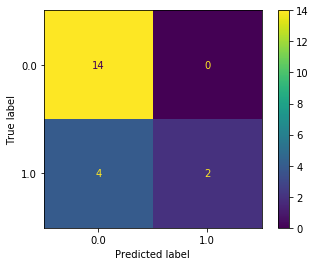

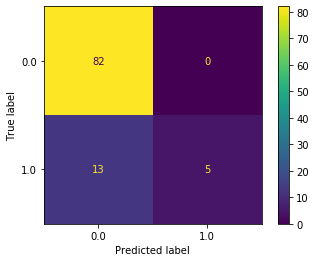

In [38]:
_X = np.array([[0,0,0]])
_Y = np.array([[]])

maxStops = max(stats3.m_met.apply(lambda x: len(x)))

for i in range(maxStops):
    X_raw, y = preprocess_slices(slices, i)
    X = scaler.transform(X_raw)
    _X = np.concatenate((_X, X))
    _Y = np.append(_Y, y)
    

_X = np.delete(_X, 0, 0)

print(len(_X))

X_train, X_test, y_train, y_test = train_test_split(
    _X, 
    _Y, 
    test_size=0.2, 
    random_state=42)

print(len(X_train))
print(len(X_test))

svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

plot_confusion_matrix(svc, X_test, y_test)
plt.savefig("confusion.jpg")
plt.show() 

plot_confusion_matrix(svc, _X, _Y)
plt.savefig("confusionBIG.jpg")
plt.show() 

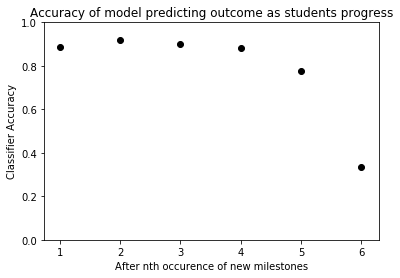

In [39]:
maxStops = max(stats3.m_met.apply(lambda x: len(x)))

nstudents = len(stats)
for i in range(maxStops):

    X_raw, y= preprocess_slices(slices, i)

    X = scaler.transform(X_raw)

    sc = svc.score(X, y)

    #predicted to complete
    plt.scatter(i, sc, c='black')



plt.xlabel("After nth occurence of new milestones")
plt.ylabel("Classifier Accuracy")
plt.xticks(ticks=list(range(0, maxStops)), labels=list(range(1, maxStops+1)))
plt.ylim(0, 1.0)
plt.title("Accuracy of model predicting outcome as students progress")
plt.savefig("completionPredictPCT.png")
plt.show()

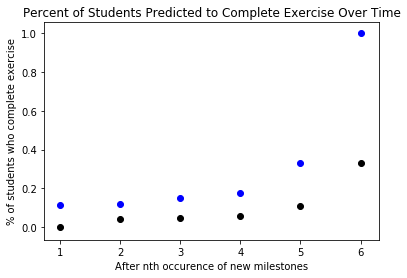

In [40]:
for i in range(maxStops):

    X_raw, y= preprocess_slices(slices, i)

    X = scaler.transform(X_raw)

    ct = svc.predict(X)
    sTrue = np.sum(ct)
    
    #predicted to complete
    plt.scatter(i, sTrue/len(ct), c='black')

    #plot actual here 
    plt.scatter(i, np.sum(y)/len(y), c='blue')


plt.xlabel("After nth occurence of new milestones")
plt.ylabel("% of students who complete exercise")
plt.xticks(ticks=list(range(0, maxStops)), labels=list(range(1, maxStops+1)))
plt.title("Percent of Students Predicted to Complete Exercise Over Time")
plt.savefig("completionPredict.png")
plt.show()